In [231]:
from PIL import Image
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from wordcloud import WordCloud
from scipy.stats import zscore
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder




## Erste Datenanalyse

* Jede Zeile unseres Datensatzes besteht aus einem String und boolean
* Analyse mit NumPy/Pandas nicht möglich
* Daher verwenden wir ein Bild eingelesen als array

In [232]:
image = Image.open('Data/PulledPork.jpg')

# Bild in ein NumPy-Array umwandeln
image_array = np.array(image)

In [233]:
spam_dataset = pd.read_csv('Data/spam_dataset.csv')
spam_dataset.head()

,message_content,is_spam
0,"Hello Lonnie,\n\nJust wanted to touch base regarding our project’s next steps. Please find the details below. Information material statement power suddenly summer usually. Serious responsibility before new success each.\n\nKind regards,\nTerry Griffin\n\nPlease find attached the updated project plan. Let me know if you have any questions.\n\nIf you have any questions, please feel free to reach out.",0
1,"Congratulations, you've won a prize! Call us now to claim it.\n\nYour account has been selected for a special reward. Click here to claim it now!\n\nFor more details, visit our website or contact us directly.",1
2,"You have been pre-approved for a credit card with a high limit.\n\nThis special offer is available for a limited time only. Act quickly to secure your spot.\n\nFor more details, visit our website or contact us directly.",1
3,"Limited time offer, act now! Only a few spots left.\n\nImmediate action required! Verify your account details to avoid suspension.\n\nFor more details, visit our website or contact us directly.",1
4,"Your loan has been approved! Transfer funds today.\n\nHurry! This is a once-in-a-lifetime opportunity that you don't want to miss. Act now!\n\nFor more details, visit our website or contact us directly.",1


In [234]:
r_channel_pixel_values = image_array[:, :, 0].flatten()
g_channel_pixel_values = image_array[:, :, 1].flatten()
b_channel_pixel_values = image_array[:, :, 2].flatten()

# Satische Analyse
* Sind die Daten homogen verteilt?
    * Nein, siehe Histogramm
* Gibt es Ausreißer?
    * Bei einem Schwellenwert ab 2.5 x Standardabweichung nicht
    * Bei einem Schwellenwert <= 2 x Standardabweichung ja (23892 Ausreißer bei 2)


In [235]:
# Statistische Analyse der Pixelwerte
mean_value = np.mean(r_channel_pixel_values)
median_value = np.median(r_channel_pixel_values)
std_dev = np.std(r_channel_pixel_values)

print(f"Mittelwert der Pixelwerte: {mean_value}")
print(f"Median der Pixelwerte: {median_value}")
print(f"Standardabweichung der Pixelwerte: {std_dev}")

# Schwellenwert für Ausreißer 
# (z.B. 3 Standardabweichungen vom Mittelwert entfernt)
upper_limit = mean_value + 2 * std_dev
lower_limit = mean_value - 2 * std_dev


outliers = np.sum((r_channel_pixel_values > upper_limit) | (r_channel_pixel_values < lower_limit))
print(f"Anzahl der Ausreißer: {outliers}")


Mittelwert der Pixelwerte: 105.629503125
Median der Pixelwerte: 100.0
Standardabweichung der Pixelwerte: 69.36882514398872
Anzahl der Ausreißer: 23892


## Kannst du durch die statistischen Werte schon irgenwelche Schlüsse aus deinen Daten ziehen?
   * Durch den Mittelwert der Farbkanäle erkennt man das die Pixel durchschnittlich eher Rötlich sind

In [236]:
r_channel_mean_value = np.mean(r_channel_pixel_values)
g_channel_mean_value = np.mean(g_channel_pixel_values)
b_channel_mean_value = np.mean(b_channel_pixel_values)

print(f"Mittelwert der Pixelwerte (R-Kanal): {r_channel_mean_value}")
print(f"Mittelwert der Pixelwerte (G-Kanal): {g_channel_mean_value}")
print(f"Mittelwert der Pixelwerte (B-Kanal): {b_channel_mean_value}")

Mittelwert der Pixelwerte (R-Kanal): 105.629503125
Mittelwert der Pixelwerte (G-Kanal): 95.24125833333333
Mittelwert der Pixelwerte (B-Kanal): 89.60549166666667


## Histogram der Pixelwerte (R-Kanal)

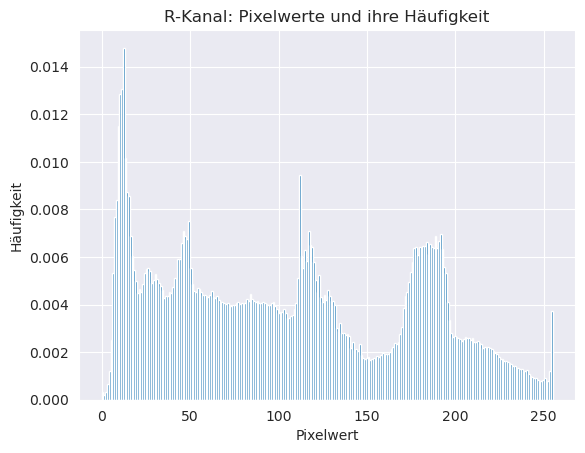

In [237]:
plt.hist(r_channel_pixel_values, bins=256, range=(0, 255), density=True)
plt.title('R-Kanal: Pixelwerte und ihre Häufigkeit')
plt.xlabel('Pixelwert')
plt.ylabel('Häufigkeit')
plt.show()

# Suche dir eine Spalte zum Sortieren deiner Daten und gib die 3 höchsten und die drei niedrigsten Werte aus
* Höchste und niedrigste Pixelwerte
* Längste und Kürzeste Emails

In [238]:
sorted_pixels = np.sort(r_channel_pixel_values)

print(f"3 niedrigste Pixelwerte: {sorted_pixels[:3]}")
print(f"3 höchste Pixelwerte: {sorted_pixels[-3:]}")


3 niedrigste Pixelwerte: [0 0 0]
3 höchste Pixelwerte: [255 255 255]


In [239]:
lengths = spam_dataset['message_content'].apply(len).tolist()

sorted_lengths = sorted(lengths)

lowest_3 = sorted_lengths[:3]
highest_3 = sorted_lengths[-3:]

print(f"3 kürzeste Emails: {lowest_3}")
print(f"3 längste Emails: {highest_3}")

3 kürzeste Emails: [162, 162, 162]
3 längste Emails: [511, 511, 514]


Erstelle ein neues NumPy Array mit nur einer Spalte aus deinem Datensatz.

In [240]:
red_channel = image_array[:, :, 0]  # Roter Kanal

# Ausgabe der ersten 5 Werte der neuen Spalte
print(red_channel[:5])

[[254 254 254 ...  30  28  26]
 [254 254 254 ...  32  30  28]
 [254 254 254 ...  34  32  31]
 [254 254 254 ...  35  33  32]
 [254 254 254 ...  42  41  38]]


## Unterschiede Numpy und Pandas
* Numpy ist für numerische Berechnungen optimiert
* Pandas ist für Datenanalyse optimiert
* Numpy ist schneller als Pandas
* Numpy ist besser für mathematische Operationen
* Pandas ist besser für Datenmanipulation
* Numpy ist besser für 1D Arrays

# Visualisierung


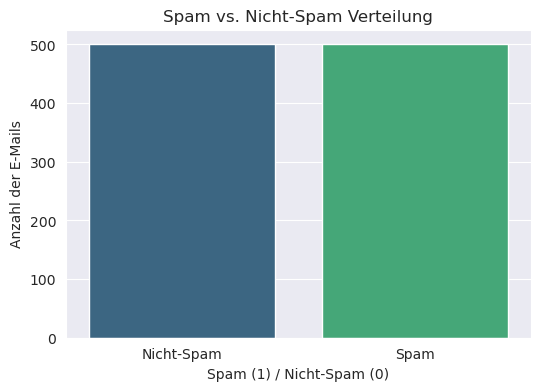

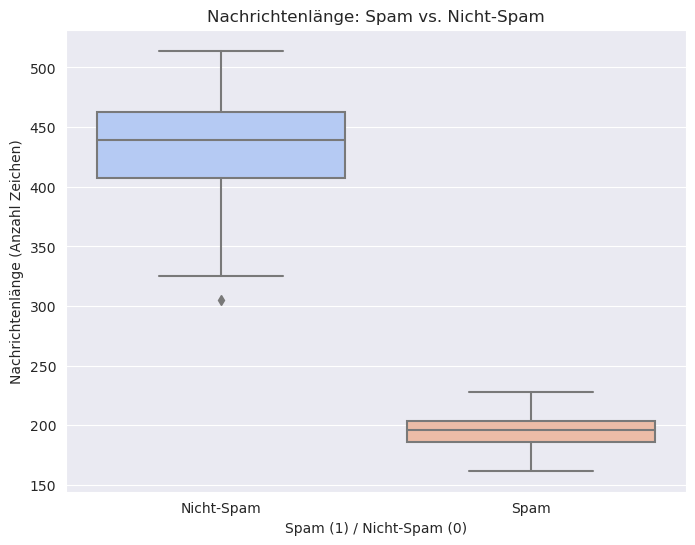

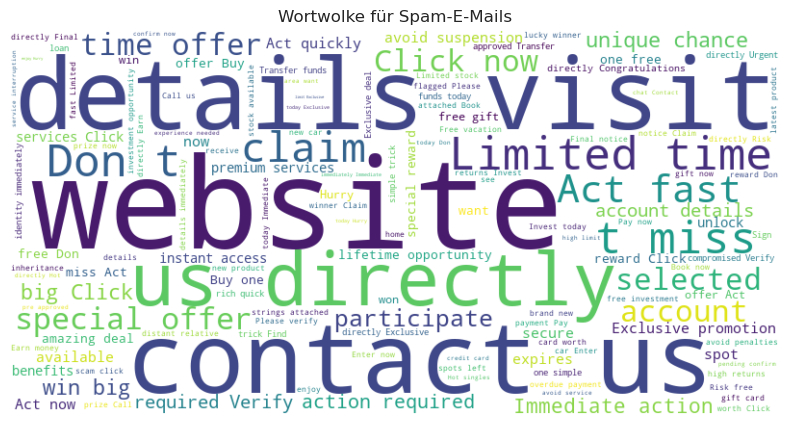

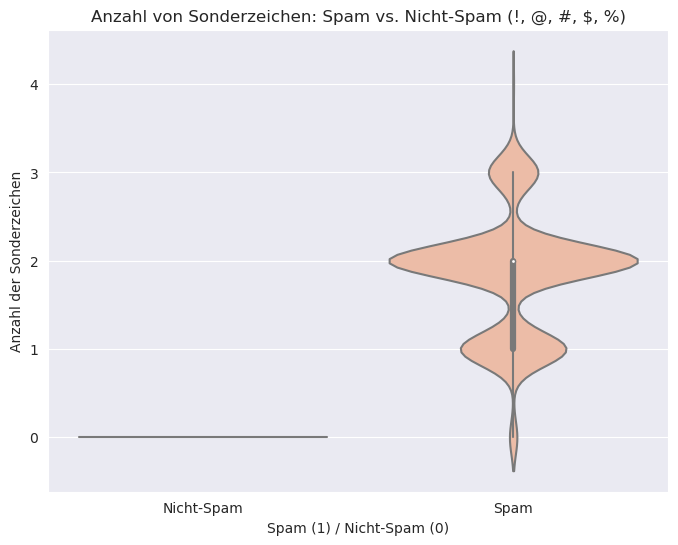

In [241]:
# Spam vs. Nicht-Spam Verteilung
spam_counts = spam_dataset['is_spam'].value_counts()

plt.figure(figsize=(6, 4))
sns.barplot(x=spam_counts.index, y=spam_counts.values, palette='viridis')
plt.title('Spam vs. Nicht-Spam Verteilung')
plt.xlabel('Spam (1) / Nicht-Spam (0)')
plt.ylabel('Anzahl der E-Mails')
plt.xticks([0, 1], ['Nicht-Spam', 'Spam'])
plt.show()

# Durchschnittliche Länge der E-Mails in Bezug auf Spam vs. Nicht-Spam
spam_dataset['message_length'] = spam_dataset['message_content'].apply(len)

plt.figure(figsize=(8, 6))
sns.boxplot(x='is_spam', y='message_length', data=spam_dataset, palette='coolwarm')
plt.title('Nachrichtenlänge: Spam vs. Nicht-Spam')
plt.xlabel('Spam (1) / Nicht-Spam (0)')
plt.ylabel('Nachrichtenlänge (Anzahl Zeichen)')
plt.xticks([0, 1], ['Nicht-Spam', 'Spam'])
plt.show()

# Wortwolke für Spam-E-Mails
spam_words = ' '.join(spam_dataset[spam_dataset['is_spam'] == 1]['message_content'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(spam_words)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Wortwolke für Spam-E-Mails')
plt.show()

# Verteilung der Sonderzeichen in Spam vs. Nicht-Spam
spam_dataset['special_char_count'] = spam_dataset['message_content'].str.count(r'[!@#$%&]')

# Erstellen eines Violinplots
plt.figure(figsize=(8, 6))
sns.violinplot(x='is_spam', y='special_char_count', data=spam_dataset, palette='coolwarm')
plt.title('Anzahl von Sonderzeichen: Spam vs. Nicht-Spam (!, @, #, $, %)')
plt.xlabel('Spam (1) / Nicht-Spam (0)')
plt.ylabel('Anzahl der Sonderzeichen')
plt.xticks([0, 1], ['Nicht-Spam', 'Spam'])
plt.show()

 # Data Preperation

In [242]:
sleep_dataset = pd.read_csv('Data/student_sleep_patterns.csv')
sleep_dataset.head()

,Student_ID,Age,Gender,University_Year,Sleep_Duration,Study_Hours,Screen_Time,Caffeine_Intake,Physical_Activity,Sleep_Quality,Weekday_Sleep_Start,Weekend_Sleep_Start,Weekday_Sleep_End,Weekend_Sleep_End
0,1,24,Other,2nd Year,7.7,7.9,3.4,2,37,10,14.16,4.05,7.41,7.06
1,2,21,Male,1st Year,6.3,6.0,1.9,5,74,2,8.73,7.10,8.21,10.21
2,3,22,Male,4th Year,5.1,6.7,3.9,5,53,5,20.00,20.47,6.88,10.92
3,4,24,Other,4th Year,6.3,8.6,2.8,4,55,9,19.82,4.08,6.69,9.42
4,5,20,Male,4th Year,4.7,2.7,2.7,0,85,3,20.98,6.12,8.98,9.01


In [243]:
duplikate = sleep_dataset[sleep_dataset.duplicated()]
if not duplikate.empty:
    print(f"Es gibt {duplikate.shape[0]} Duplikate im Datensatz.")
    print("Die Duplikate sind:")
    print(duplikate)
else:
    print("Es gibt keine Duplikate im Datensatz.")

Es gibt keine Duplikate im Datensatz.


Gibt es Daten die nicht relevant sind?

NAN Values verändern:

In [244]:
gender_mapping = {'Male': 1, 'Female': 2, 'Other': 3}
university_mapping = {'1st Year': 1, '2nd Year': 2, '3rd Year': 3, '4th Year': 4}
sleep_dataset['Gender'] = sleep_dataset['Gender'].map(gender_mapping)
sleep_dataset['University_Year'] = sleep_dataset['University_Year'].map(university_mapping)
sleep_dataset.head()

,Student_ID,Age,Gender,University_Year,Sleep_Duration,Study_Hours,Screen_Time,Caffeine_Intake,Physical_Activity,Sleep_Quality,Weekday_Sleep_Start,Weekend_Sleep_Start,Weekday_Sleep_End,Weekend_Sleep_End
0,1,24,3,2,7.7,7.9,3.4,2,37,10,14.16,4.05,7.41,7.06
1,2,21,1,1,6.3,6.0,1.9,5,74,2,8.73,7.10,8.21,10.21
2,3,22,1,4,5.1,6.7,3.9,5,53,5,20.00,20.47,6.88,10.92
3,4,24,3,4,6.3,8.6,2.8,4,55,9,19.82,4.08,6.69,9.42
4,5,20,1,4,4.7,2.7,2.7,0,85,3,20.98,6.12,8.98,9.01


In [245]:
encoder = OneHotEncoder(sparse_output=False)

gender_encoded = encoder.fit_transform(sleep_dataset[['Gender']])

gender_encoded_df = pd.DataFrame(gender_encoded, columns=['isMale', 'isFemale', 'isOther'])

sleep_dataset = pd.concat([sleep_dataset, gender_encoded_df], axis=1)

sleep_dataset.drop('Gender', axis=1, inplace=True)

encoder = OneHotEncoder(sparse_output=False)

# Fit and transform the 'University_Year' column
uni_year_encoded = encoder.fit_transform(sleep_dataset[['University_Year']])

# Create a DataFrame from the transformed data with new column names
uni_year_encoded_df = pd.DataFrame(uni_year_encoded, columns=encoder.get_feature_names_out(['University_Year']))

# Concatenate the new DataFrame with the original dataset
sleep_dataset = pd.concat([sleep_dataset, uni_year_encoded_df], axis=1)

# Drop the original 'University_Year' column
sleep_dataset.drop('University_Year', axis=1, inplace=True)

sleep_dataset.head()



,Student_ID,Age,Sleep_Duration,Study_Hours,Screen_Time,Caffeine_Intake,Physical_Activity,Sleep_Quality,Weekday_Sleep_Start,Weekend_Sleep_Start,Weekday_Sleep_End,Weekend_Sleep_End,isMale,isFemale,isOther,University_Year_1,University_Year_2,University_Year_3,University_Year_4
0,1,24,7.7,7.9,3.4,2,37,10,14.16,4.05,7.41,7.06,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,2,21,6.3,6.0,1.9,5,74,2,8.73,7.10,8.21,10.21,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,3,22,5.1,6.7,3.9,5,53,5,20.00,20.47,6.88,10.92,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,4,24,6.3,8.6,2.8,4,55,9,19.82,4.08,6.69,9.42,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,5,20,4.7,2.7,2.7,0,85,3,20.98,6.12,8.98,9.01,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [246]:
numeric_cols = sleep_dataset.select_dtypes(include=['float64', 'int64']).columns
z_scores = sleep_dataset[numeric_cols].apply(zscore)

outliers_zscore = (z_scores > 3) | (z_scores < -3)
outliers_indices = outliers_zscore.any(axis=1)
outliers_data = sleep_dataset[outliers_indices]
outliers_data


,Student_ID,Age,Sleep_Duration,Study_Hours,Screen_Time,Caffeine_Intake,Physical_Activity,Sleep_Quality,Weekday_Sleep_Start,Weekend_Sleep_Start,Weekday_Sleep_End,Weekend_Sleep_End,isMale,isFemale,isOther,University_Year_1,University_Year_2,University_Year_3,University_Year_4


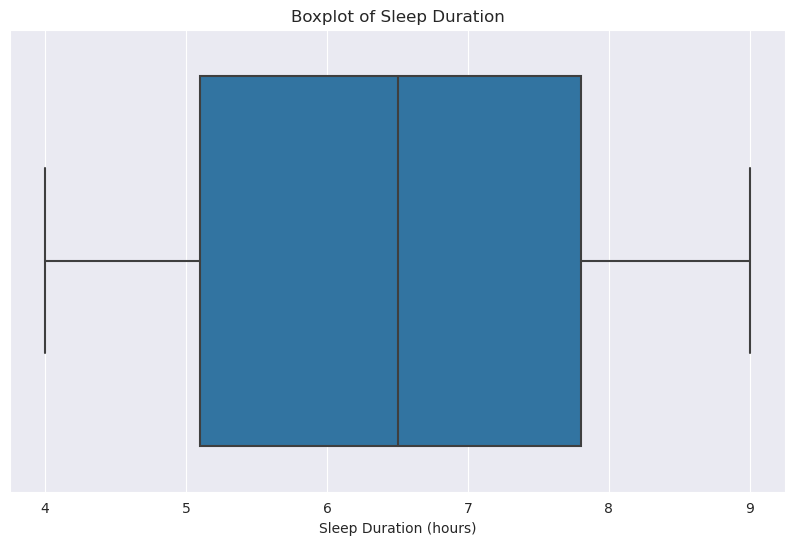

In [247]:

plt.figure(figsize=(10, 6))
sns.boxplot(x=sleep_dataset['Sleep_Duration'])
plt.title('Boxplot of Sleep Duration')
plt.xlabel('Sleep Duration (hours)')
plt.show()

## Ausreißer:
Da es keine Ausreißer gibt, können wir die Daten so lassen wie sie sind.

# Skalierung

In [248]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# Select the numeric columns to scale
numeric_cols = sleep_dataset.select_dtypes(include=['float64', 'int64']).columns

# Fit and transform the data
sleep_dataset[numeric_cols] = scaler.fit_transform(sleep_dataset[numeric_cols])

# Display the first few rows of the scaled dataset
sleep_dataset.head()

,Student_ID,Age,Sleep_Duration,Study_Hours,Screen_Time,Caffeine_Intake,Physical_Activity,Sleep_Quality,Weekday_Sleep_Start,Weekend_Sleep_Start,Weekday_Sleep_End,Weekend_Sleep_End,isMale,isFemale,isOther,University_Year_1,University_Year_2,University_Year_3,University_Year_4
0,0.000000,0.857143,0.74,0.655462,0.800000,0.4,0.308333,1.000000,0.627338,0.100251,0.605528,0.010076,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0.002004,0.428571,0.46,0.495798,0.300000,1.0,0.616667,0.111111,0.366906,0.253133,0.806533,0.803526,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.004008,0.571429,0.22,0.554622,0.966667,1.0,0.441667,0.444444,0.907434,0.923308,0.472362,0.982368,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.006012,0.857143,0.46,0.714286,0.600000,0.8,0.458333,0.888889,0.898801,0.101754,0.424623,0.604534,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0.008016,0.285714,0.14,0.218487,0.566667,0.0,0.708333,0.222222,0.954436,0.204010,1.000000,0.501259,1.0,0.0,0.0,0.0,0.0,0.0,1.0


# Data Validation

## Regression
* Welche Werte können mit Regression vorhergesagt werden?
    * Schlafdauer, Studienzeit, Bildschirmzeit, Koffeinaufnahme, körperliche Aktivität, Schlafqualität
* Vorbereitungsschritte
    * Kategorische Werte in numerische Werte umwandeln
    * Skalierung der numerichen Werte
* Wie gut funktioniert das Modell?
    * Nicht gut, da die Daten nicht linear sind
* Interpretation der Confusion Matrix
    * Die Werte schräg von oben links nach unten rechts sind die korrekten Vorhersagen

In [254]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score

X = sleep_dataset.drop(columns=['Sleep_Duration'])
y = sleep_dataset['Sleep_Duration']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Add polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Train the Ridge regression model
ridge = Ridge(alpha=1.0)
ridge.fit(X_train_poly, y_train)

# Make predictions
y_pred = ridge.predict(X_test_poly)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 0.10893125904295926
R^2 Score: -0.13078808824549615


## Decision Tree
Für Deciscion Tree verwenden wir den Spam Datensatz

* Welche Klassen
    * Span, Nicht-Spam 
* Datensatz ist Ausgeglichen
* Vorverarbeitungsschritte
    * keine  
* Wie gut funktioniert das Modell
    * Perfekt 

Confusion Matrix:
[[ 99   0]
 [  0 101]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        99
           1       1.00      1.00      1.00       101

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



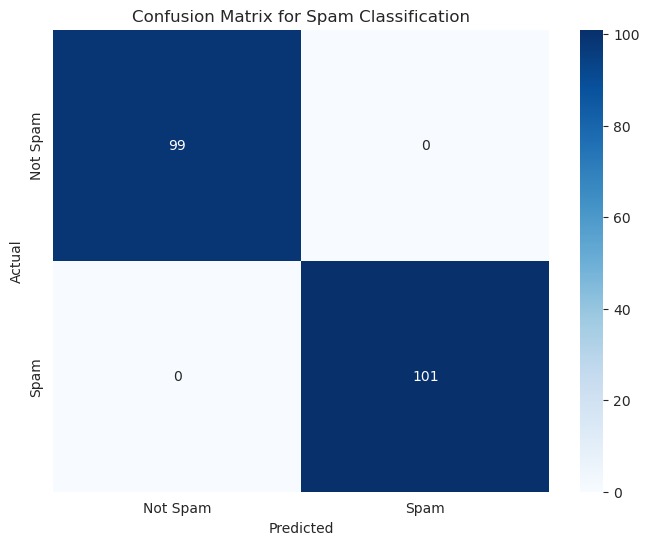

In [250]:



X = spam_dataset['message_content']
y = spam_dataset['is_spam']

# Convert text data to numerical data using TF-IDF Vectorizer
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Decision Tree model
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Spam', 'Spam'], yticklabels=['Not Spam', 'Spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Spam Classification')
plt.show()

# Klassifikation mit Decision Tree und Random Forest
* Vorhersage des Geschlechts anhand der Schlafdaten

Confusion Matrix:
[[ 99   0]
 [  0 101]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        99
           1       1.00      1.00      1.00       101

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



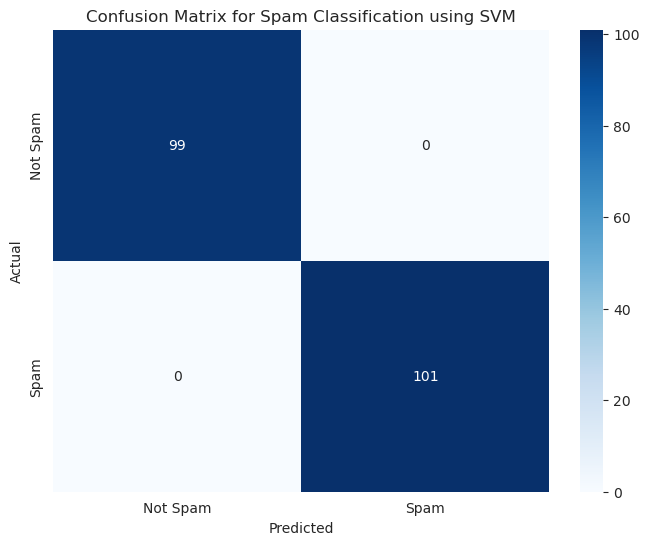

In [251]:
# Import the SVM classifier
from sklearn.svm import SVC

# Prepare the data (already done in your code)
X = spam_dataset['message_content']
y = spam_dataset['is_spam']

# Convert text data to numerical data using TF-IDF Vectorizer
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the SVM model
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)

# Make predictions
y_pred = svm_model.predict(X_test)

# Evaluate the model
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Spam', 'Spam'], yticklabels=['Not Spam', 'Spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Spam Classification using SVM')
plt.show()
